In [1]:
import astropy.io.fits as fits
import numpy as np
import os
import pylab as pl

from IPython.display import YouTubeVideo
from scipy import interpolate
from scipy import optimize
from spectres import spectres

# Parallactic Distance, Spctroscopic Distance and Photometric Distnace

The cosmic distance ladder is the succession of methods to determine the distances to celestial objects. A direct distance measurement of an astronomical source is possible only for the nearby targets. The techniques for determining distances to more distant objects are all based on various measured correlations between methods that work at close distances and methods that work at larger distances. Some of these methods rely on standard candles, which are astronomical objects with known (but not necessarily constant) luminosity.

## Trigonometric Parallax
For the most nearby objects, we can measure the distance with trigonometric parallax. As the result of the Earth orbiting the Sun, the position of nearby stars show relative motions compared to the more distant background. The nearer the star, the larger the parallax, vice versa. This provides one of the most fundamental distance measurement in Astronomy.

## Spectroscopic Distance
Same type of objects have the same spectral energy distribution, i.e. spectrum. By having these objects at a known distance from the trionometric parallax, we know the normalisation of the spectrum, i.e. the luminosity. Through fitting both the shape and the normalisation of the observed spectrum with template or model spectra, we can obtain the object properties including the distance - the spectroscopic distance.

## Photometric Distance
The flux in a photometric band is the flux summed over a well-defined range of wavelengths. With multiple photometric bands, we can obtain the colour of the sources. You may see it as a form of extremely low resolution spectrum. The rest follows the same as the spectroscopic distance. The main difference is its lower accuracy because less infomation is avaible from the integrated flux over a large range of wavlengths.



### See the video below for the illustraction of finding distance with parallax and different standard candles.

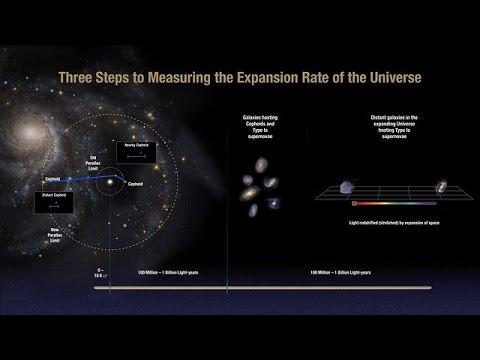

In [2]:
YouTubeVideo('sQbtjUgIVhg', width=800, height=400)

In this Notebook, we illustrate how the distance can be found from spectrum and photometry (for the parallactic distance, we take the values as given from the complex computation done by the European Space Agency). We will illustrate the methods with a white dwarf.

The photometric models we are going to use are the pure hydrogen atmosphere models in the Gaia passbands from the University of Montreal (http://www.astro.umontreal.ca/~bergeron/CoolingModels/, and see references therein). The spectral models are taken from Levenhagen 2017 model (https://ui.adsabs.harvard.edu/abs/2017ApJS..231....1L).

The photometric data and the computed distance (https://ui.adsabs.harvard.edu/abs/2018AJ....156...58B/) can be found at the Gaia Archive (https://gea.esac.esa.int/archive/) or the CDS Vizier (http://vizier.u-strasbg.fr/). The spectroscopic data are provided by the DESI collaboration.

## 1. Load the Models

### Model - Gaia photometry

In [3]:
# Load the pure hydrogen atmosphere WD model (DA white dwarf)
model_phot_da = np.genfromtxt('../dat/WDphot/Table_DA.txt', skip_header=2)

T_da = model_phot_da[:,0]
logg_da = model_phot_da[:,1]
mass_da = model_phot_da[:,2]
mbol_da = model_phot_da[:,3]
G_da = model_phot_da[:,-6]
Gbp_da = model_phot_da[:,-5]
Grp_da = model_phot_da[:,-4]

In [4]:
# Interpolate over the model grid
G_interpolator_da = interpolate.CloughTocher2DInterpolator((T_da, logg_da), G_da, rescale=True)
Gbp_interpolator_da = interpolate.CloughTocher2DInterpolator((T_da, logg_da), Gbp_da, rescale=True)
Grp_interpolator_da = interpolate.CloughTocher2DInterpolator((T_da, logg_da), Grp_da, rescale=True)

### Model - Model DA spectra

In [5]:
spec_da_list = os.listdir('../dat/WDspec/')
model_flux_spec_da = []
model_wave_spec_da = []
T_spec_da = []
logg_spec_da = []

for filename in spec_da_list:
    if filename[-4:] != '.npz':
        continue
    model = np.load('../dat/WDspec/' + filename)['arr_0']
    model_flux_spec_da.append(model[:,1])
    model_wave_spec_da.append(model[:,0])
    T, logg = filename.split('.')[0].split('t0')[-1].split('g')
    T_spec_da.append(float(T) * 1000.)
    logg_spec_da.append(float(logg[:-1]) / 10.)

## 2. Load the Data

### Data - distance derived from Gaia parallax

In [6]:
# Distance calculated from Gaia parallax using proper statistical treatment (Bailer-Jones et al. 2018)
dist_para = 784.665266 # parcsecs

### Data - Gaia photometry

In [7]:
# Observed Gaia magnitudes (Vega magnitude)
G_obs = 19.5145
Gbp_obs = 19.3481
Grp_obs = 19.7099
G_obs_err = 0.0044
Gbp_obs_err = 0.0281
Grp_obs_err = 0.0780

# Pivot wavelengths for the Gaia DR2 passbands
G_wave = 6230.6
Gbp_wave = 5051.5
Grp_wave = 7726.2

# Converting to flux
G_obs_flux = 10.**(-(G_obs + (25.7934 - 25.6884)) / 2.5) * 3631. / 3.34e4 / G_wave**2.
Gbp_obs_flux = 10.**(-(Gbp_obs + (25.3806 - 25.3514)) / 2.5) * 3631. / 3.34e4 / Gbp_wave**2.
Grp_obs_flux = 10.**(-(Grp_obs + (25.1161 - 24.7619)) / 2.5) * 3631. / 3.34e4 / Grp_wave**2.

### Data - DESI spectrum

In [8]:
# Load the DESI spectrum
zbest = fits.open('../student_andes/zbest-mws-66003-20200315-wd.fits')[1]
coadd = fits.open('../student_andes/coadd-mws-66003-20200315-wd.fits')

In [9]:
# Get the position
ra, dec = float(zbest.data['TARGET_RA']), float(zbest.data['TARGET_DEC'])

# Get the wavelength and flux
wave = coadd[1].data['WAVELENGTH']
count = coadd[1].data['TARGET35191335094848528']

Text(0.5, 1.0, 'TARGET35191335094848528')

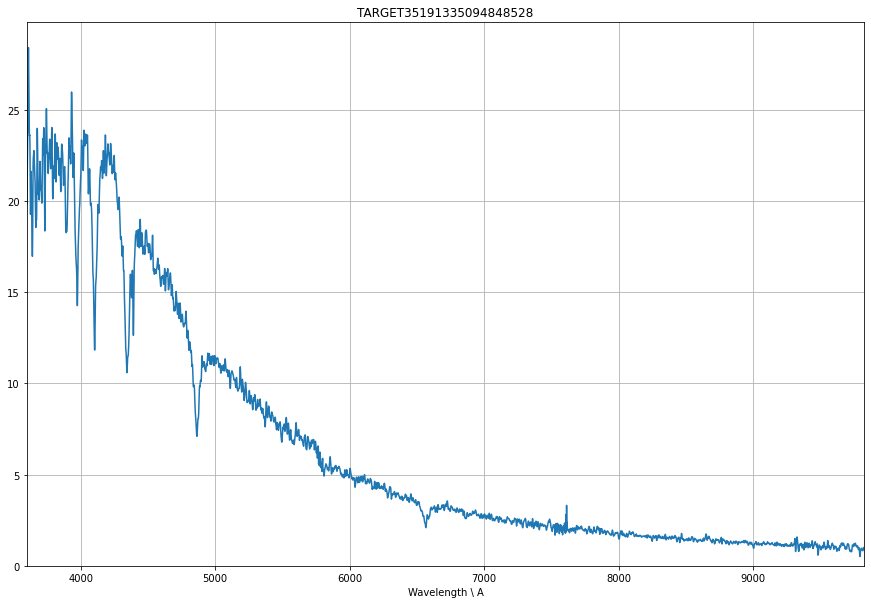

In [10]:
# Plotting the spectrum
pl.figure(figsize=(15, 10))
pl.plot(wave, count)
pl.grid()
pl.xlabel('Wavelength \ A')
pl.xlim(min(coadd[1].data['WAVELENGTH']), max(coadd[1].data['WAVELENGTH']))
pl.ylim(ymin=0.)
pl.title('TARGET35191335094848528')

## 3. Find the best-fit spectral model

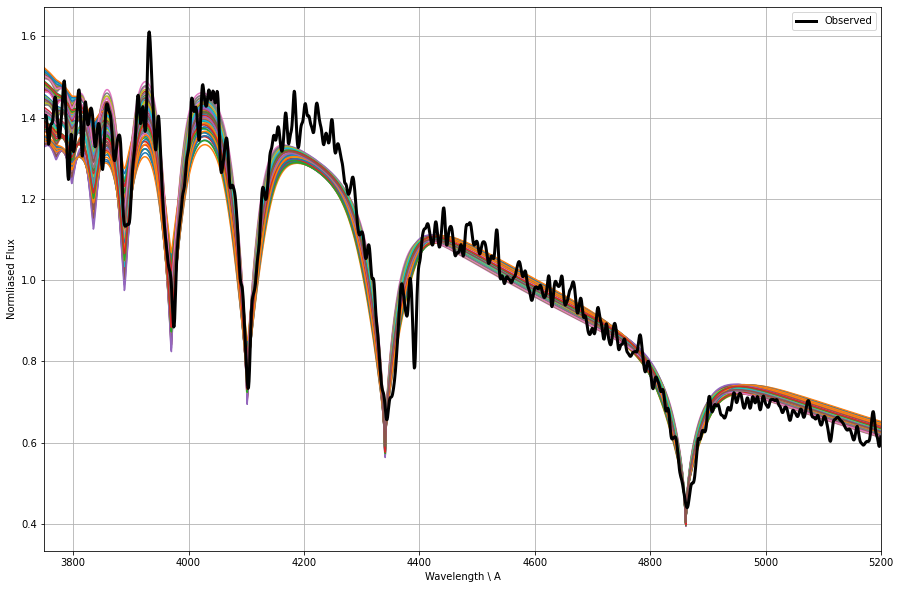

In [11]:
# wavelength range to be fitted
wave_min = 3750.
wave_max = 5200.

sq_diff = []
pl.figure(figsize=(15, 10))

for model_wave, model_flux in zip(model_wave_spec_da, model_flux_spec_da):
    # Resample the model resoltuion to match the observed spectrum
    model_flux_resampled = spectres(wave, model_wave, model_flux, fill=0., verbose=False)
    # Masking the range to be fitted
    fitted_range = (wave > wave_min) & (wave < wave_max)
    # Compute the sum of the squared difference of the individually normalised model and observed spectra
    sq_diff.append(np.sum((model_flux_resampled[fitted_range] / np.median(model_flux_resampled[fitted_range]) - count[fitted_range] / np.median(count[fitted_range]))**2.))
    # Plot the model
    pl.plot(wave[fitted_range], model_flux_resampled[fitted_range] / np.median(model_flux_resampled[fitted_range]))

# Plot the DESI spectrum
pl.plot(wave[fitted_range], count[fitted_range] / np.median(count[fitted_range]), label='Observed', color='black', lw=3)
# Other commands to set the plot
pl.xlim(wave_min, wave_max)
pl.legend()
pl.xlabel('Wavelength \ A')
pl.ylabel('Normliased Flux')
pl.grid()

# Unit-weighted least-squared best-fit surface gravity and temperature from the DESI spctrum
arg_min = np.argmin(sq_diff)
T_desi = T_spec_da[arg_min]
logg_desi = logg_spec_da[arg_min]

Text(0.5, 1.0, 'TARGET35191335094848528 :   T = 26000.0 K   log(g) = 7.6')

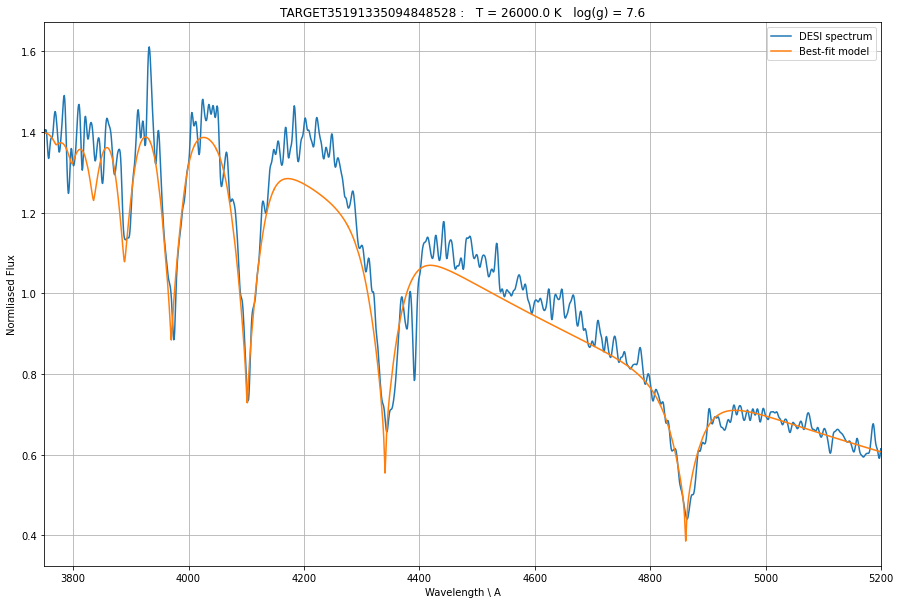

In [12]:
# Plot the best fit only
fitted_range = (model_wave_spec_da[arg_min] > wave_min) & (model_wave_spec_da[arg_min] < wave_max)
fitted_range_data = (wave > wave_min) & (wave < wave_max)

pl.figure(figsize=(15, 10))
pl.plot(wave[fitted_range_data], count[fitted_range_data] / np.median(count[fitted_range_data]), label='DESI spectrum')
pl.plot(model_wave_spec_da[arg_min][fitted_range], model_flux_spec_da[arg_min][fitted_range] / np.median(model_flux_spec_da[arg_min][fitted_range]), label='Best-fit model')
pl.grid()
pl.xlim(wave_min, wave_max)
pl.xlabel('Wavelength \ A')
pl.ylabel('Normliased Flux')
pl.legend()
pl.title('TARGET35191335094848528 :   T = ' + str(T_desi) + ' K   log(g) = ' + str(logg_desi))

## 4. Find the spectroscopic distance

In [13]:
# The expected absolute magnitude in the Gaia colours are
G_desi = G_interpolator_da(T_desi, logg_desi)
Gbp_desi = Gbp_interpolator_da(T_desi, logg_desi)
Grp_desi = Grp_interpolator_da(T_desi, logg_desi)

# The distance modulus
dist_mod_G_desi = G_obs - G_desi
dist_mod_Gbp_desi = Gbp_obs - Gbp_desi
dist_mod_Grp_desi = Grp_obs - Grp_desi

# The medan distance modulus
dist_mod_mean_desi = np.mean((dist_mod_G_desi, dist_mod_Gbp_desi, dist_mod_Grp_desi))

# Converting the distance modulus back to distance
dist_spec = 10.**((dist_mod_mean_desi + 5.) / 5.) 

print('This Spectroscopic distance is %s pc' % dist_spec)

This Spectroscopic distance is 940.4879199247991 pc


## 5. Find the photometric distance

The Gaia photometry are only avaiable in 3 filters, so we can only fit for 2 variables. This is more commonly performed with more filters, but in this demonstration we will stick to the same data set and use the surface gravity found from the spectroscopic fit.

In [14]:
# Define the least-square fucntion
def t_logg_fit(params, obs):
    # Unpack the input
    T, dist = params
    if (dist < 1.) or (T < 2500.) or (T > 1E+5):
        return np.inf
    logg, G_obs, Gbp_obs, Grp_obs, G_obs_err, Gbp_obs_err, Grp_obs_err = obs
    # Get the distance modulus
    dist_mod = 5. * np.log10(dist) - 5.
    # Get the model magnitude and apply the distance modulus
    G_model = G_interpolator_da(T, logg) + dist_mod
    Gbp_model = Gbp_interpolator_da(T, logg) + dist_mod
    Grp_model = Grp_interpolator_da(T, logg) + dist_mod
    # Check finite
    if not (np.isfinite(G_model) & np.isfinite(Gbp_model) & np.isfinite(Grp_model)):
        return np.inf
    else:
        return ((G_model - G_obs)/G_obs_err)**2. + ((Gbp_model - Gbp_obs)/Gbp_obs_err)**2. + ((Grp_model - Grp_obs)/Grp_obs_err)**2.

In [15]:
lsq_solution = optimize.minimize(
    t_logg_fit,
    [25000, 1000.],
    [logg_desi, G_obs, Gbp_obs, Grp_obs, G_obs_err, Gbp_obs_err, Grp_obs_err],
    method='Nelder-Mead')
T_phot = lsq_solution.x[0]
dist_phot = lsq_solution.x[1]

In [16]:
print('Photometric distance from Gaia photometry alone is %s pc' %dist_phot)

Photometric distance from Gaia photometry alone is 820.8206910532908 pc
